## Описание задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Описание полей данных:
* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд,
* PaperlessBilling – безналичный расчет,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время звонка

Информация о договорах актуальна на 1 февраля 2020.

## Импорт

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


#Библиотека sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle #метод shuffle для перемешивания данных
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

import xgboost as xgb
import lightgbm as lgb

#Модели библиотеки Catboost
#pip install catboost
from catboost import CatBoost, CatBoostClassifier

#Библиотека scipy
from scipy import stats as st 

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 14})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.simplefilter('ignore')

## Загрузка и обзор данных

Загружаем данные

In [3]:
contract = pd.read_csv('final_provider/final_provider/contract.csv')
internet = pd.read_csv('final_provider/final_provider/internet.csv')
personal = pd.read_csv('final_provider/final_provider/personal.csv')
phone = pd.read_csv('final_provider/final_provider/phone.csv')

In [4]:
def data_overview(data):
    """
    Выводит первые строки датафрейма, информацию о нем и статистику по столбцам
    """
    display(data.head())
    print()
    print(data.info())
    print()
    print('Дубликатов:', data.duplicated().sum())
    try:
        display(data.select_dtypes(exclude=["object"]).describe())
    except:
        print('No num data in dataframe')
    print()
    try:
        display(data.select_dtypes(exclude=[np.number]).describe())
    except:
        print('No cat data in dataframe')
    print()

Посмотрим, что содержится в каждой таблице. В случае необходимости проведем предобработку.

In [5]:
data_overview(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Дубликатов: 0


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5174,3875,4171,2365,11


В таблице contract 8 столбцов и 7043 строки. Пропусков нет. Дубликатов нет. Данные в столбцах BeginDate, EndDate и TotalCharges не соответствуют записанным в них данным. Поменяем типы данных.

In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


В данных появились пропуски. В столбце EndDate у тех клиентов, кто не расторгал договор, а в столбце TotalCharges у тех, кто является клиентом первый месяц. Заполним пропуски.

In [8]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

Переходим к следующей таблице

In [9]:
data_overview(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Дубликатов: 0
No num data in dataframe



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


В таблице phone 2 столбца и 6361 строк. Пропусков нет, дубликатов нет, с типами данных все в порядке. Строк меньше, чем в таблице contract, значит данные есть не обо всех клиентах, а только о тех, кто пользуется телефоном.

In [10]:
data_overview(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Дубликатов: 0
No num data in dataframe



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


В таблице internet 8 столбцов и 5517 строк. Пропусков нет, дубликатов нет, с типами данных все в порядке. Строк меньше, чем в таблице contract, значит данные есть не обо всех клиентах, а только о тех, кто пользуется интернетом.

In [11]:
data_overview(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Дубликатов: 0


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


В таблице perconal 5 столбцов и 7043 строк. Пропусков нет, дубликатов нет, с типами данных все в порядке, но данные записаны по разному - в столбце SeniorCitizen это цифры 1 и 0, а в Partner и Dependents слова Yes и No. В дальнейшем перед обучением моделей все это нужно будет перевести в числовой формат с помощью кодирования. Строк столько же, как и в таблице contract, значит данные есть обо всех клиентах.

## Исследовательский анализ данных

Перед анализом объединим все данные в одном датафрейме.

In [12]:
full_data = contract.merge(personal, on='customerID', how='left')
full_data = full_data.merge(phone, on='customerID', how='left')
full_data = full_data.merge(internet, on='customerID', how='left')

In [13]:
full_data.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No


In [14]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     6361 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

Заполним образовавшиеся пропуски в информации о телефоне и интернете значением 'Not in use'.

In [15]:
full_data[['MultipleLines', 'InternetService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 
           'StreamingTV', 'StreamingMovies']] = full_data[[
    'MultipleLines', 'InternetService', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies']].fillna('Not in use')

### Создание дополнительных признаков

Создадим три дополнительных признака: 

1) Срок давности заключенных договоров (количество дней). Для договоров, которые не были расторгуты, в качестве конечной даты используем 1 февраля 2020 года.

2) Факт расторжения договора (целевой)

3) Тип используемых сервисов

In [16]:
full_data['DaysFromBegin'] = full_data['EndDate'] - full_data['BeginDate']
full_data['DaysFromBegin'] = full_data['DaysFromBegin'].fillna(pd.to_datetime('2020-02-01') - full_data['BeginDate'])
full_data['DaysFromBegin'] = full_data['DaysFromBegin'].dt.days

In [17]:
full_data['Churn'] = (~full_data['EndDate'].isna()).astype('int')

In [18]:
full_data['Services'] = 0 # person use All main services
full_data.loc[full_data['MultipleLines'] == 'Not in use', 'Services'] = 1 # person use only Internet service
full_data.loc[full_data['InternetService'] == 'Not in use', 'Services'] = 2 # person use only Phone service

In [19]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

### Распределение используемых услуг

In [20]:
alpha = 0.05
def table_for_chi2(col_group):
    table1 = full_data.groupby(col_group, as_index=False)['Churn'].sum()
    table2 = full_data.groupby(col_group, as_index=False)['customerID'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'customerID':'All', 'Churn':'Gone'}, inplace = True)
    merge['Not_gone'] = merge['All'] - merge['Gone']
    merge = merge.drop('All', axis=1)
        
    stat, p, dof, expected = chi2_contingency(merge[['Gone', 'Not_gone']])
      
    return merge, p

In [21]:
def chi2_display_res(merge, p, alpha):
    display(merge)
    print('p-значение:', p)
    if p < alpha:
        print('Отклонить нулевую гипотезу')
    else:
        print('Не получилось отклонить нулевую гипотезу')

In [22]:
def countplot_x(feature, hue, title):
    sns.set()
    sns.countplot(feature, hue = hue)
    plt.title(title)

In [23]:
def pie_plot(labels, title, col):
    fig = plt.figure()
    plt.title(title)
    plt.axis('off')

    ax0 = fig.add_axes([.25, .3, .5, .5], aspect=1)
    fracs = full_data[col].value_counts().values
    ax0.pie(fracs, labels=labels, radius = 1.2, startangle=90)
    ax0.set_xlabel('Все клиенты')

    ax1 = fig.add_axes([0, -.4, .5, .5], aspect=1)
    fracs = full_data.query('Churn == 0')[col].value_counts().values
    ax1.pie(fracs, labels=labels, radius = 1.2, startangle=90)
    ax1.set_xlabel('Лояльные клиенты')


    ax2 = fig.add_axes([.5, -.4, .5, .5], aspect=1)
    fracs = full_data.query('Churn == 1')[col].value_counts().values
    ax2.pie(fracs, labels=labels, radius = 1.2, startangle=90)
    ax2.set_xlabel('Ушедшие клиенты')

    plt.show()

In [24]:
def ttest_res(col):
    mean_gone = full_data.query('Churn == 1')[col].mean()
    mean_not_gone = full_data.query('Churn == 0')[col].mean()
    print('Среднее по ушедшим клиентам', mean_gone)
    print('Среднее по оставшимся клиентам', mean_not_gone)
    results = st.ttest_ind(full_data.query('Churn == 1')[col], full_data.query('Churn == 0')[col])
    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

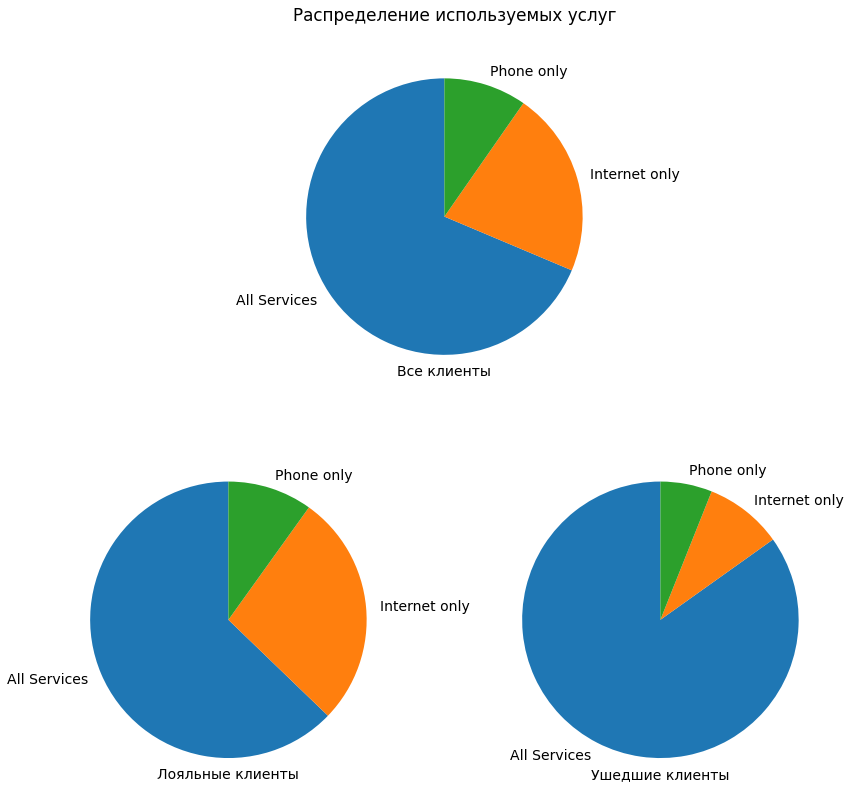

,Services,Gone,Not_gone
0,0,1586,3249
1,1,170,512
2,2,113,1413


p-значение: 2.780885838634751e-84
Отклонить нулевую гипотезу


In [25]:
labels = ['All Services', 'Internet only', 'Phone only']
title = "Распределение используемых услуг"

pie_plot(labels, title, 'Services')
chi2_display_res(*table_for_chi2('Services'), alpha)

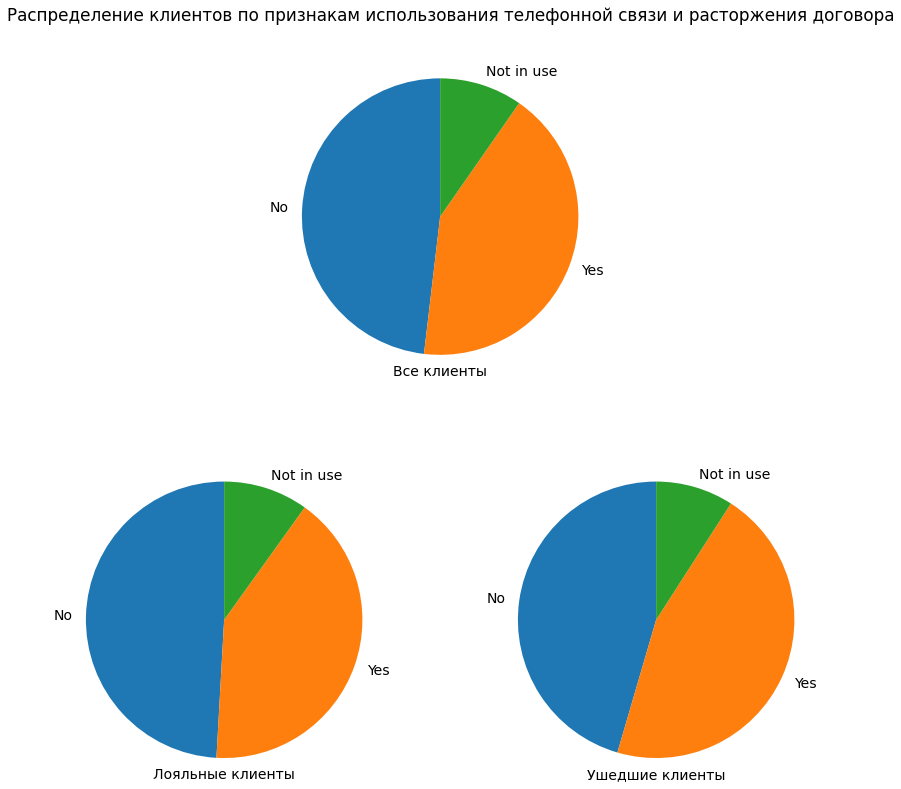

,MultipleLines,Gone,Not_gone
0,No,849,2541
1,Not in use,170,512
2,Yes,850,2121


p-значение: 0.0034643829548773038
Отклонить нулевую гипотезу


In [26]:
labels = full_data['MultipleLines'].value_counts().index.tolist()
title = "Распределение клиентов по признакам использования телефонной связи и расторжения договора"

pie_plot(labels, title, 'MultipleLines')
chi2_display_res(*table_for_chi2('MultipleLines'), alpha)

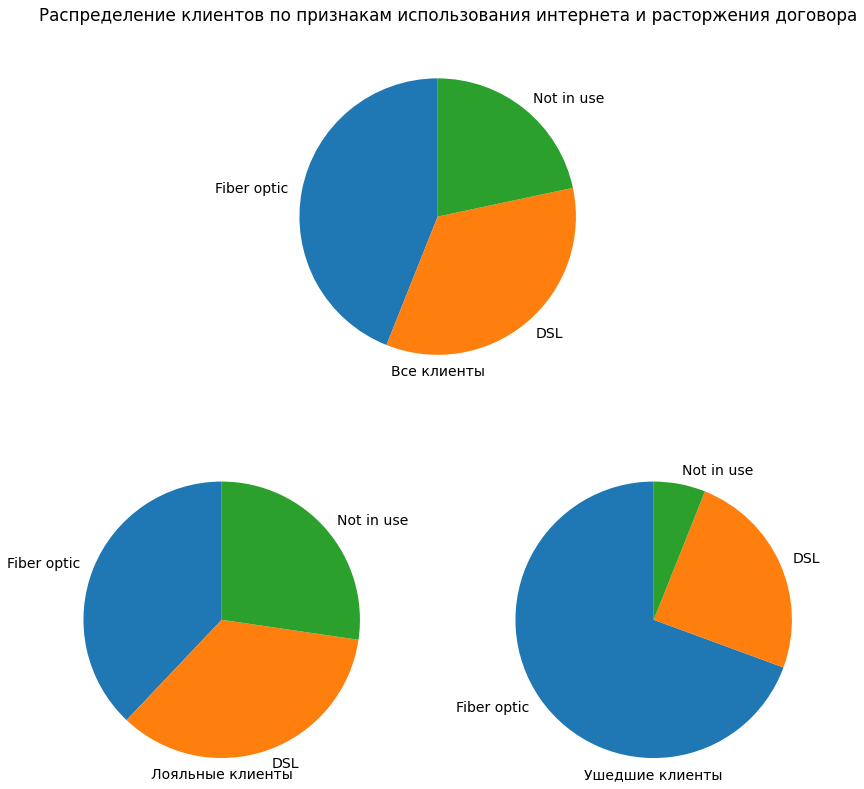

,InternetService,Gone,Not_gone
0,DSL,459,1962
1,Fiber optic,1297,1799
2,Not in use,113,1413


p-значение: 9.571788222840544e-160
Отклонить нулевую гипотезу


In [27]:
labels = full_data['InternetService'].value_counts().index.tolist()
title = 'Распределение клиентов по признакам использования интернета и расторжения договора'

pie_plot(labels, title, 'InternetService')
chi2_display_res(*table_for_chi2('InternetService'), alpha)

На графиках мы видим, что среди лояльных клиентов есть значительная доля тех, кто пользуется только одним сервисом, в первую очередь интернетом, среди ушедших клиентов подавляющее большинство использовало все услуги. Рассматривая отдельные услуги, можно сказать, что менее довольны пользователи нескольких линий по сравнению с одной, и DSL по сравнению с оптоволокном.

### Данные о времени использования

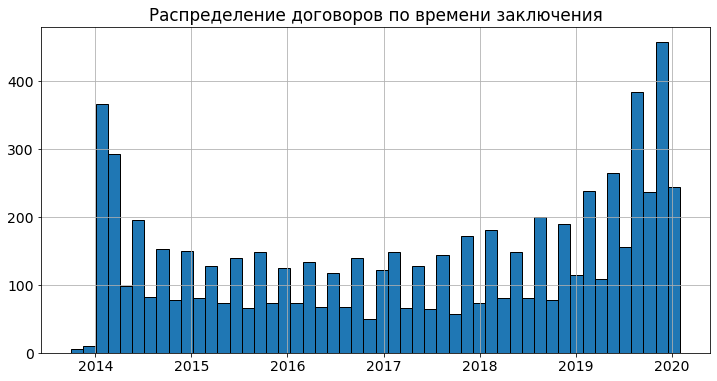

In [28]:
full_data['BeginDate'].hist(figsize=(12, 6), bins=50, edgecolor="black")
plt.title('Распределение договоров по времени заключения')
plt.show()

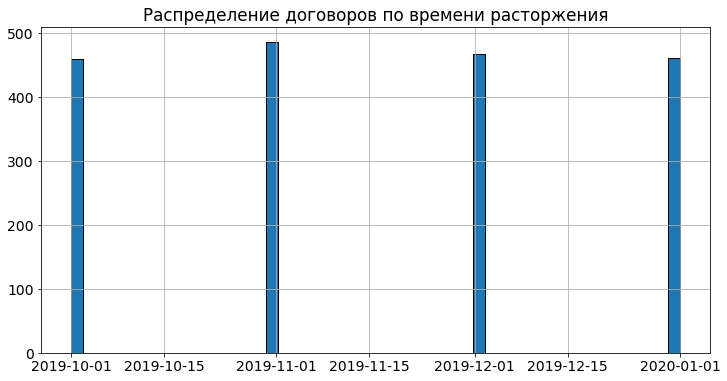

In [29]:
full_data['EndDate'].hist(figsize=(12, 6), bins=50, edgecolor="black")
plt.title('Распределение договоров по времени расторжения')
plt.show()

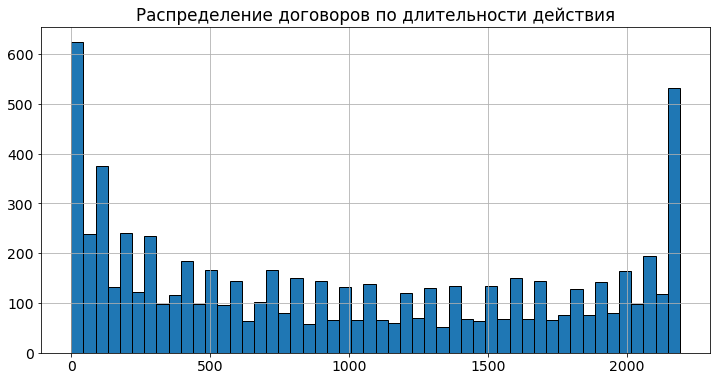

In [30]:
full_data['DaysFromBegin'].hist(figsize=(12, 6), bins=50, edgecolor="black")
plt.title('Распределение договоров по длительности действия')
plt.show()

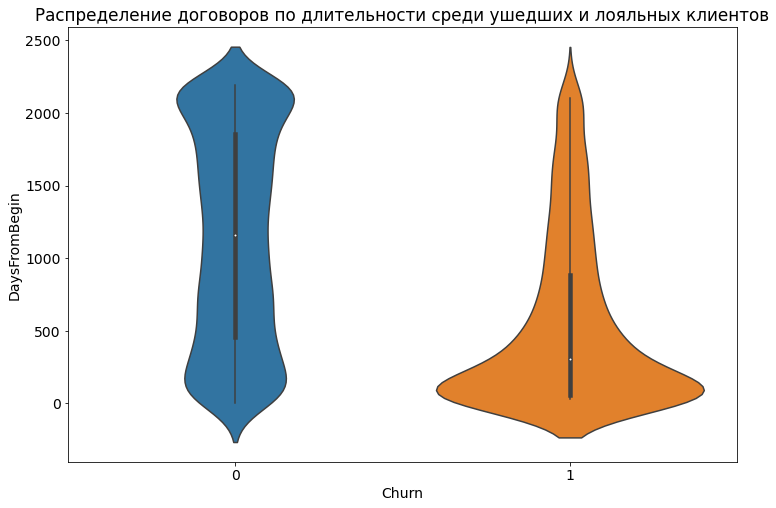

In [31]:
ax = sns.violinplot(data=full_data, y='DaysFromBegin' , x='Churn')
plt.title('Распределение договоров по длительности среди ушедших и лояльных клиентов')
plt.show()

In [32]:
ttest_res('DaysFromBegin')

Среднее по ушедшим клиентам 547.3520599250936
Среднее по оставшимся клиентам 1144.4472361809046
p-значение:  2.2675899587603997e-205
Отвергаем нулевую гипотезу


На графиках мы видим, что договора активно заключались в 2014 году, затем был спад с постепенным ростом к 2020 году. А вот дат расторжения договоров всего 4 и все они только в 2019 и 2020 годах. В данном случае причина возможно в том, что данные искуственные, но на реальных данных необходимо было бы в первую очередь проверить, что происходило в эти даты. При рассмотрении графиков длительности действия договоров мы можем увидеть, что большая часть договоров расторгается через короткое время после заключения,  а старые клиенты уходят реже.

### Данные о затратах

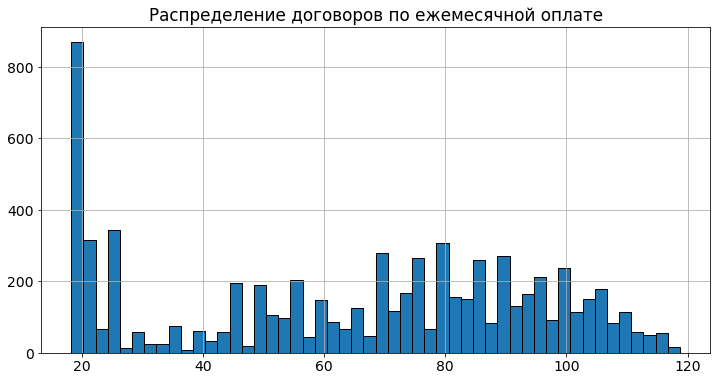

In [33]:
full_data['MonthlyCharges'].hist(figsize=(12, 6), bins=50, edgecolor="black")
plt.title('Распределение договоров по ежемесячной оплате')
plt.show()

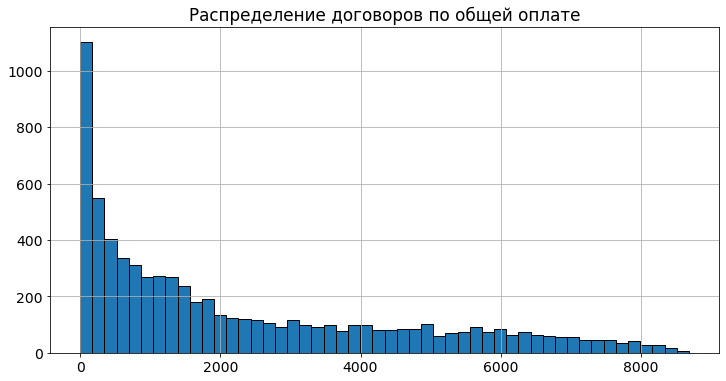

In [34]:
full_data['TotalCharges'].hist(figsize=(12, 6), bins=50, edgecolor="black")
plt.title('Распределение договоров по общей оплате')
plt.show()

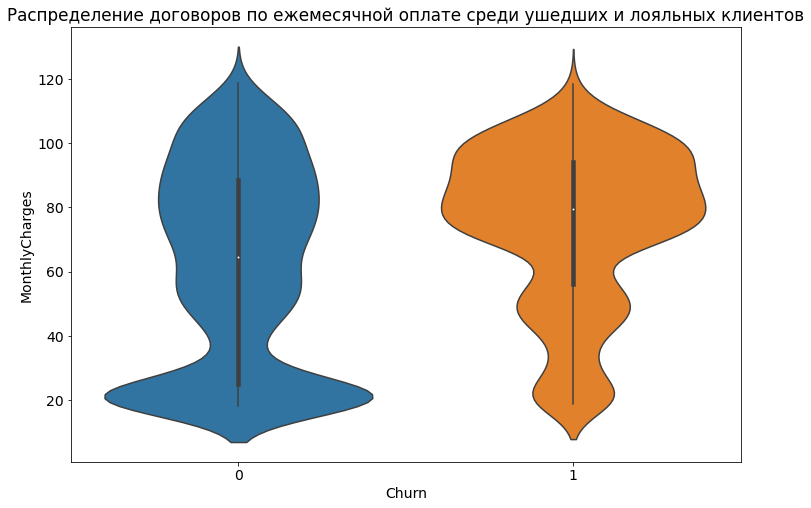

In [35]:
ax = sns.violinplot(data=full_data, y='MonthlyCharges' , x='Churn')
plt.title('Распределение договоров по ежемесячной оплате среди ушедших и лояльных клиентов')
plt.show()

In [36]:
ttest_res('MonthlyCharges')

Среднее по ушедшим клиентам 74.4413322632423
Среднее по оставшимся клиентам 61.2651236953999
p-значение:  2.706645606888261e-60
Отвергаем нулевую гипотезу


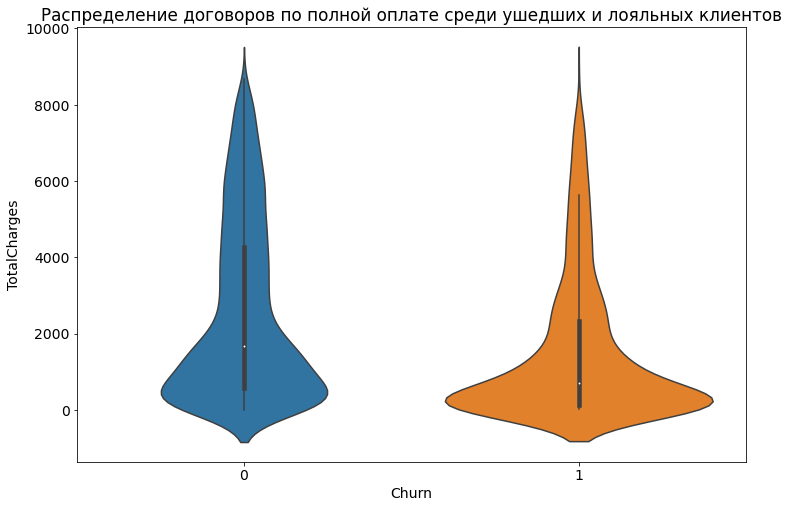

In [37]:
sns.violinplot(x='Churn', y='TotalCharges', data=full_data)
plt.title('Распределение договоров по полной оплате среди ушедших и лояльных клиентов')
plt.show()

In [38]:
ttest_res('TotalCharges')

Среднее по ушедшим клиентам 1531.7960941680035
Среднее по оставшимся клиентам 2549.911441824514
p-значение:  2.127211613240394e-63
Отвергаем нулевую гипотезу


Сравнив расторгнутые и нерасторгнутые договора, мы можем увидеть, что в расторгнутых договорах средняя ежемесячная оплата была выше, в то время как платеж за все время был ниже. 

### Данные о контракте

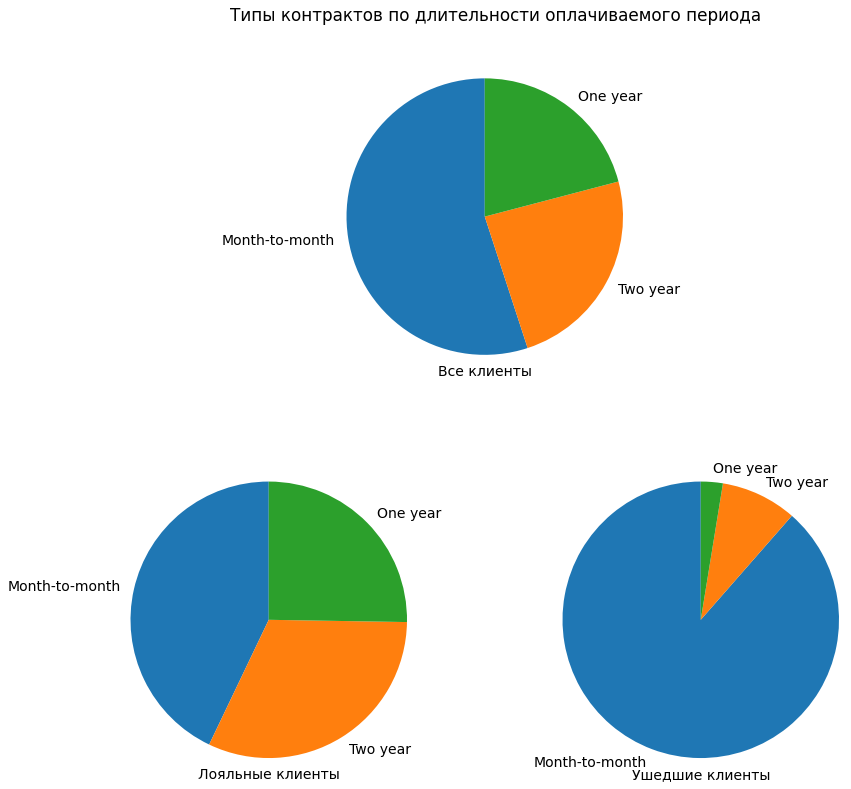

,Type,Gone,Not_gone
0,Month-to-month,1655,2220
1,One year,166,1307
2,Two year,48,1647


p-значение: 5.863038300672725e-258
Отклонить нулевую гипотезу


In [39]:
labels = full_data['Type'].value_counts().index.tolist()
title = "Типы контрактов по длительности оплачиваемого периода"

pie_plot(labels, title, 'Type')
chi2_display_res(*table_for_chi2('Type'), alpha)

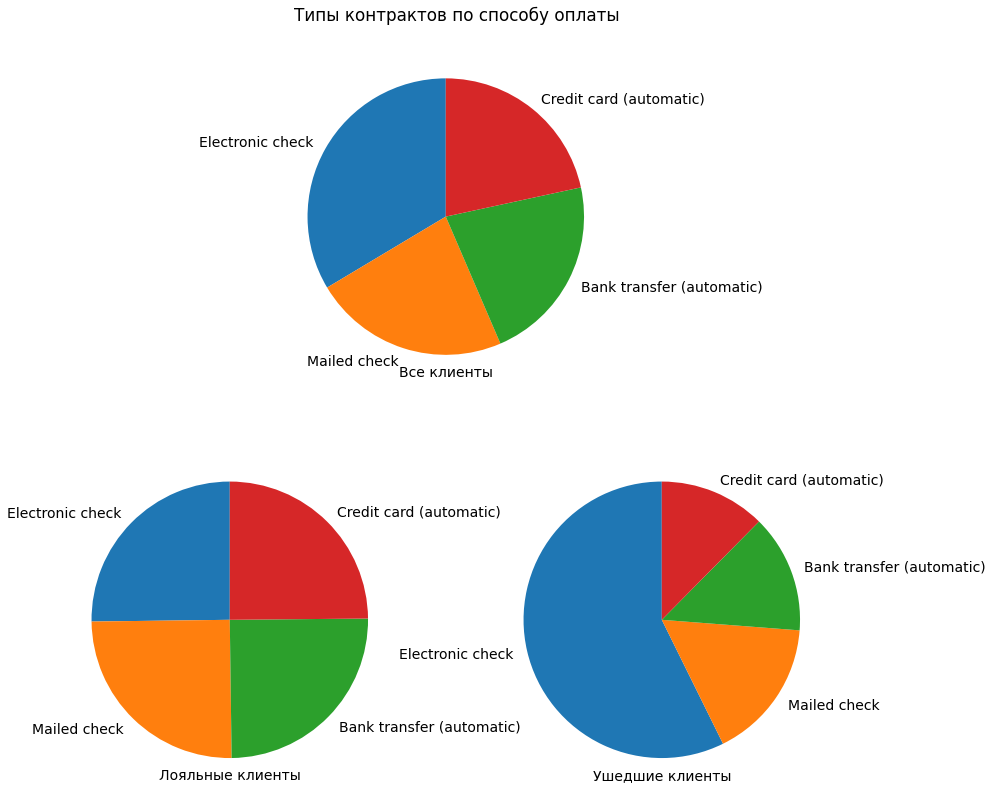

,PaymentMethod,Gone,Not_gone
0,Bank transfer (automatic),258,1286
1,Credit card (automatic),232,1290
2,Electronic check,1071,1294
3,Mailed check,308,1304


p-значение: 3.6823546520097993e-140
Отклонить нулевую гипотезу


In [40]:
labels = full_data['PaymentMethod'].value_counts().index.tolist()
title = "Типы контрактов по способу оплаты"

pie_plot(labels, title, 'PaymentMethod')
chi2_display_res(*table_for_chi2('PaymentMethod'), alpha)

Большая часть ушедших клиентов использовала помесячный способ оплаты, тогда как лояльные клиенты наравне с помесячным используют и годовой и двухгодовой планы. По способу оплаты ушедшие клиенты также отличаются от лояльных преиущественным выбором оплаты через электронный чек, тогда как автоматические способы оплаты занимают меньшую долю. 

### Данные о клиентах

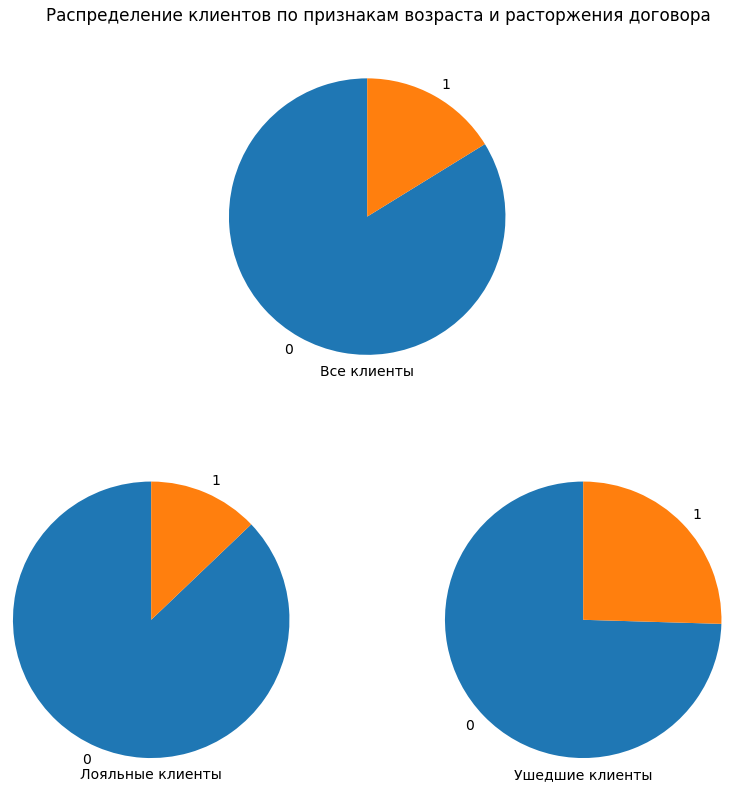

,SeniorCitizen,Gone,Not_gone
0,0,1393,4508
1,1,476,666


p-значение: 1.510066805092378e-36
Отклонить нулевую гипотезу


In [41]:
labels = full_data['SeniorCitizen'].value_counts().index.tolist()
title = 'Распределение клиентов по признакам возраста и расторжения договора'

pie_plot(labels, title, 'SeniorCitizen')
chi2_display_res(*table_for_chi2('SeniorCitizen'), alpha)

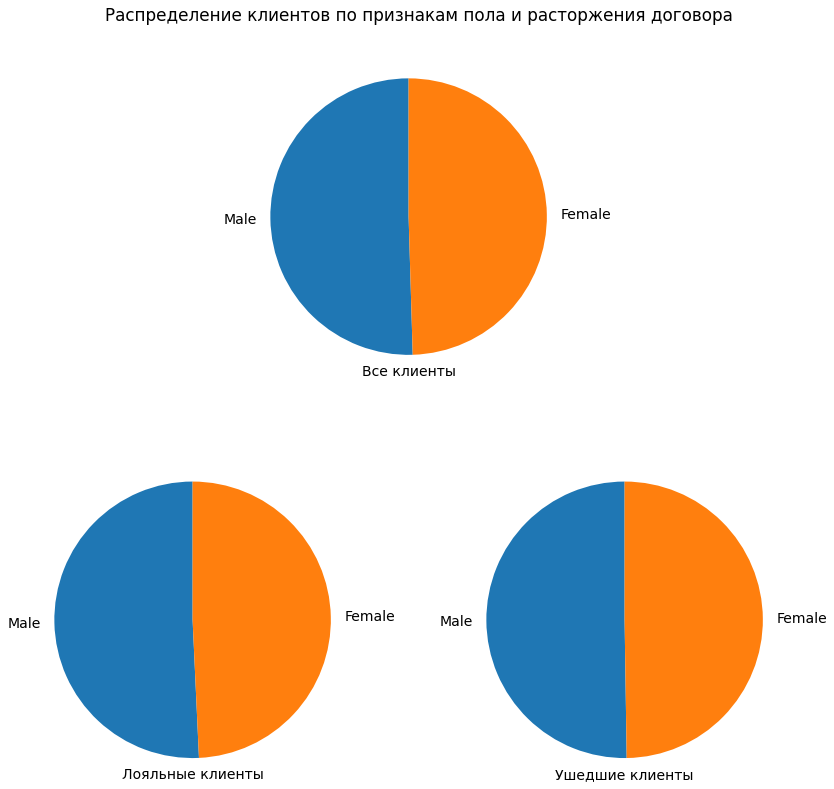

,gender,Gone,Not_gone
0,Female,939,2549
1,Male,930,2625


p-значение: 0.48657873605618596
Не получилось отклонить нулевую гипотезу


In [42]:
labels = full_data['gender'].value_counts().index.tolist()
title = 'Распределение клиентов по признакам пола и расторжения договора'

pie_plot(labels, title, 'gender')
chi2_display_res(*table_for_chi2('gender'), alpha)

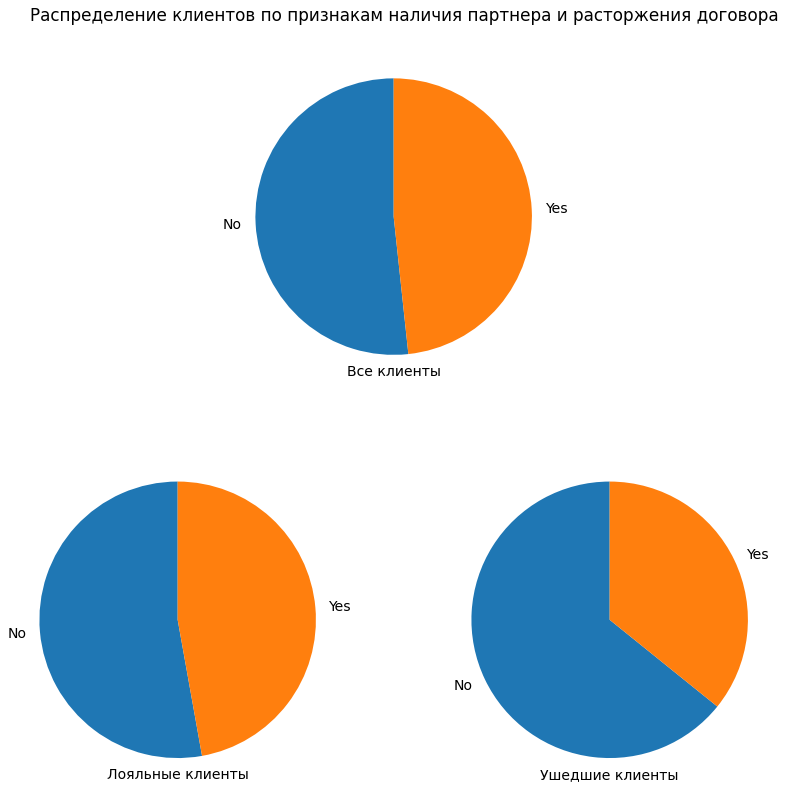

,Partner,Gone,Not_gone
0,No,1200,2441
1,Yes,669,2733


p-значение: 2.1399113440759935e-36
Отклонить нулевую гипотезу


In [43]:
labels = full_data['Partner'].value_counts().index.tolist()
title = 'Распределение клиентов по признакам наличия партнера и расторжения договора'

pie_plot(labels, title, 'Partner')
chi2_display_res(*table_for_chi2('Partner'), alpha)

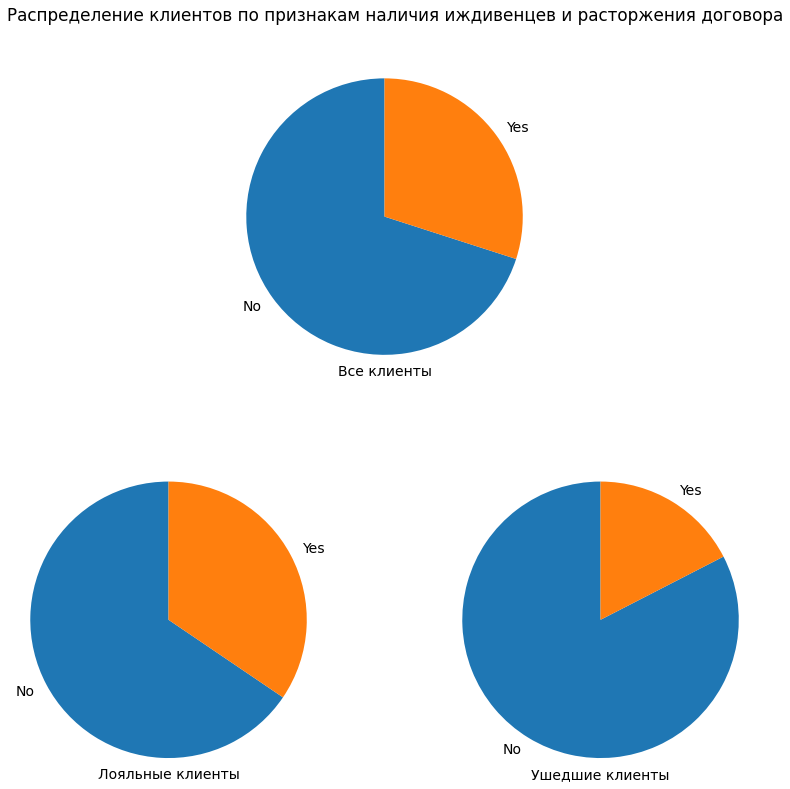

,Dependents,Gone,Not_gone
0,No,1543,3390
1,Yes,326,1784


p-значение: 4.924921661215491e-43
Отклонить нулевую гипотезу


In [44]:
labels = full_data['Dependents'].value_counts().index.tolist()
title = 'Распределение клиентов по признакам наличия иждивенцев и расторжения договора'

pie_plot(labels, title, 'Dependents')
chi2_display_res(*table_for_chi2('Dependents'), alpha)

Исходя из информации выше мы можем предположить что:  
* пол не является показателем оттока клиентов - разницы в распределении по полу среди ушедших и оставшихся клиентов нет;  
* количество людей пенсионного возраста значительно меньше, чем молодого поколения, однако отток пожилых людей почти в 2 раза больше, чем для молодых людей;  
* люди, не имеющие партнера, более склонны к расторжению договора;  
* люди без иждивенцев тоже склонны к уходу;

### Матрица корреляции

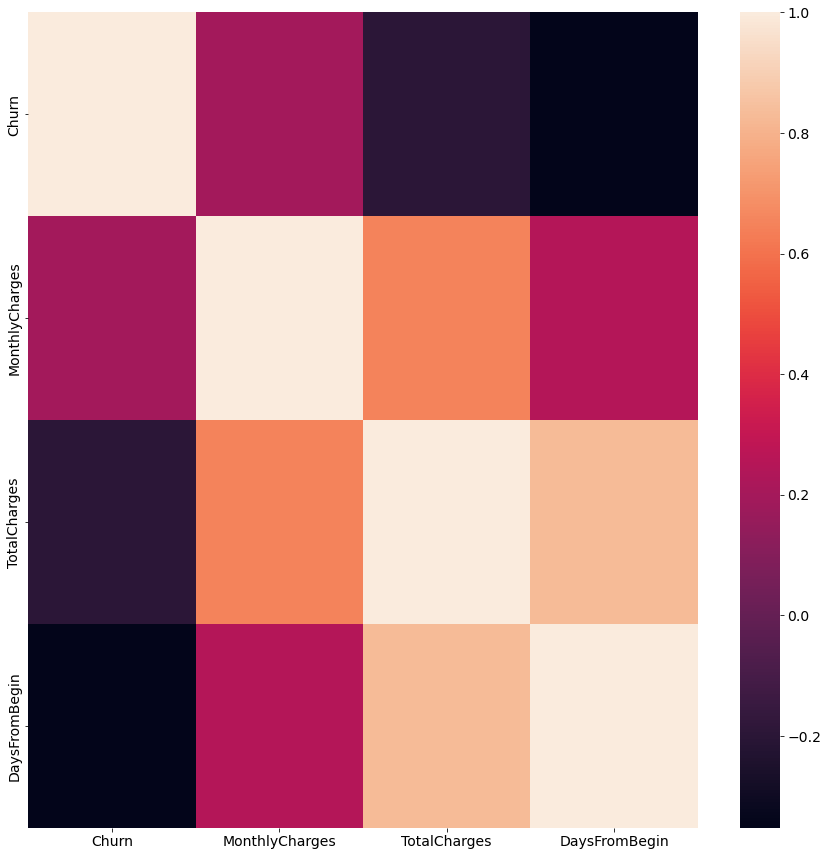

In [45]:
corrMatrix = full_data[['Churn', 'MonthlyCharges', 'TotalCharges', 'DaysFromBegin']].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=False)
plt.show()

In [46]:
full_data[['Churn', 'MonthlyCharges', 'TotalCharges', 'DaysFromBegin']].corr()

,Churn,MonthlyCharges,TotalCharges,DaysFromBegin
Churn,1.000000,0.193356,-0.198324,-0.352673
MonthlyCharges,0.193356,1.000000,0.651174,0.247754
TotalCharges,-0.198324,0.651174,1.000000,0.826109
DaysFromBegin,-0.352673,0.247754,0.826109,1.000000


Наиболее сильную корреляцию с оттоком имеет количество дней с заключения договора - оно коррелирует отрицательно - чем больше дней, тем меньше вероятность ухода.

Между собой также сильно коррелирует количество дней и общие затраты, что довольно логично, и ежемесячный платеж с общими затратами.

Остальные признаки не имеют сильно выраженной корреляции с оттоком клиентов.

## Обучение моделей

In [47]:
df = full_data
#кодируем признаки
df = df.drop(['BeginDate', 'EndDate'], axis=1)

df_to_ohe = df.drop(['customerID', 'MonthlyCharges', 'TotalCharges', 'Churn', 'DaysFromBegin'], axis=1)
df_no_ohe = df[['customerID', 'MonthlyCharges', 'TotalCharges', 'Churn', 'DaysFromBegin']]
df_to_ohe = pd.get_dummies(df_to_ohe, drop_first=True)

df = df_no_ohe.join(df_to_ohe).drop(['customerID'], axis=1)

Рассмотрим целевой признак.

In [48]:
df['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

Мы видим, что классы несбалансированы, это нужно будет учитывать при обучении модели и при рассмотрении метрики accuracy.

In [49]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12345, 
                                                       stratify = y)

print(f"Кол-во записей в обучающей выборке: {X_train.shape}")
print(f"Кол-во записей в тестовой выборке: {X_test.shape}")

Кол-во записей в обучающей выборке: (5634, 30)
Кол-во записей в тестовой выборке: (1409, 30)


In [50]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
result = []
predictions = []

### Константная модель

In [52]:
pred_bl = [0] * y.shape[0]

auc_roc = roc_auc_score(y.values, pred_bl)
accuracy = accuracy_score(y.values, pred_bl)
precision = precision_score(y.values, pred_bl)
recall = recall_score(y.values, pred_bl)

print(f"roc_auc для константной модели: {auc_roc:.3f}")
print(f"accuracy для константной модели: {accuracy:.3f}")

roc_auc для константной модели: 0.500
accuracy для константной модели: 0.735


In [53]:
result.append([accuracy, precision, recall, '-', auc_roc])

### Логистическая регрессия

In [54]:
log_reg = LogisticRegression(random_state=12345)
grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
log_reg_cv = GridSearchCV(log_reg,grid,cv=5)
log_reg_cv.fit(X_train, y_train)
auc_roc_valid = log_reg_cv.best_score_


predicted_test = log_reg_cv.best_estimator_.predict(X_test)
probabilities_test = log_reg_cv.best_estimator_.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
accuracy = accuracy_score(y_test, predicted_test)
precision = precision_score(y_test, predicted_test)
recall = recall_score(y_test, predicted_test)

print(f"roc_auc для логистической регрессии: {auc_roc:.3f}")
print(f"accuracy для логистической регрессии: {accuracy:.3f}")

result.append([accuracy, precision, recall, auc_roc_valid, auc_roc])
predictions.append(predicted_test)

roc_auc для логистической регрессии: 0.837
accuracy для логистической регрессии: 0.798


### Случайный лес

In [55]:
rand_for = RandomForestClassifier()
grid={'n_estimators': [300],
              'max_depth': [5, 7, 9],
              'max_features': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [2, 4, 6]}
rand_for_cv=GridSearchCV(rand_for,grid,cv=5)
rand_for_cv.fit(X_train, y_train)
auc_roc_valid = rand_for_cv.best_score_

predicted_test = rand_for_cv.best_estimator_.predict(X_test)
probabilities_test = rand_for_cv.best_estimator_.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
accuracy = accuracy_score(y_test, predicted_test)
precision = precision_score(y_test, predicted_test)
recall = recall_score(y_test, predicted_test)

print(f"roc_auc для случайного леса: {auc_roc:.3f}")
print(f"accuracy для случайного леса: {accuracy:.3f}")

result.append([accuracy, precision, recall, auc_roc_valid, auc_roc])
predictions.append(predicted_test)

roc_auc для случайного леса: 0.854
accuracy для случайного леса: 0.819


### CatBoost

In [56]:
cat_cl = CatBoostClassifier(
    iterations = 2000,
    custom_metric=['CrossEntropy', 'AUC:hints=skip_train~false'],
    random_state=12345, logging_level='Silent'
    )
grid = {'learning_rate': [0.2, 0,3]}
cat_cl_cv=cat_cl.grid_search(grid,X_train, y_train, cv=5)
auc_roc_valid = cat_cl.best_score_['learn']['AUC']

predicted_test = cat_cl.predict(X_test)
probabilities_test = cat_cl.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
accuracy = accuracy_score(y_test, predicted_test)
precision = precision_score(y_test, predicted_test)
recall = recall_score(y_test, predicted_test)

print(f"roc_auc для CatBoost: {auc_roc:.3f}")
print(f"accuracy для CatBoost: {accuracy:.3f}")

result.append([accuracy, precision, recall, auc_roc_valid, auc_roc])
predictions.append(predicted_test)

0:	loss: 0.3247941	best: 0.3247941 (0)	total: 5.97s	remaining: 11.9s


learning rate is greater than 1. You probably need to decrease learning rate.


1:	loss: 0.6910760	best: 0.3247941 (0)	total: 11.2s	remaining: 5.62s
Estimating final quality...
roc_auc для CatBoost: 0.907
accuracy для CatBoost: 0.869


### LightGBM

In [57]:
lgbm_cl = lgb.LGBMClassifier(objective='binary', metric='auc', random_state = 12345)

search_space_lgbm = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
                       'n_estimators': [100, 300, 500],
                       'num_leaves': [10, 20, 30, 50, 70, 100, 150]}
lgbm_cl_cv = GridSearchCV(lgbm_cl, 
                        search_space_lgbm, 
                        cv = 5)
lgbm_cl_cv.fit(X_train, y_train)

auc_roc_valid = lgbm_cl_cv.best_score_

predicted_test = lgbm_cl_cv.predict(X_test)
probabilities_test = lgbm_cl_cv.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
accuracy = accuracy_score(y_test, predicted_test)
precision = precision_score(y_test, predicted_test)
recall = recall_score(y_test, predicted_test)

print(f"roc_auc для LightGBM: {auc_roc:.3f}")
print(f"accuracy для LightGBM: {accuracy:.3f}")

result.append([accuracy, precision, recall, auc_roc_valid, auc_roc])
predictions.append(predicted_test)

roc_auc для LightGBM: 0.897
accuracy для LightGBM: 0.862


In [58]:
result = pd.DataFrame(result, columns=['accuracy', 'precision', 'recall', 'auc_roc на валиде',
                                       'auc_roc на тесте'], index=['Константная модель', 'Логистическая регрессия', 'Случайный лес', 'CatBoost', 'LightGBM'])

In [59]:
result

,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте
Константная модель,0.734630,0.000000,0.000000,-,0.500000
Логистическая регрессия,0.798439,0.634731,0.566845,0.804582,0.837053
Случайный лес,0.819021,0.717949,0.524064,0.822864,0.854220
CatBoost,0.869411,0.810458,0.663102,0.999988,0.907368
LightGBM,0.861604,0.791531,0.649733,0.85712,0.897149


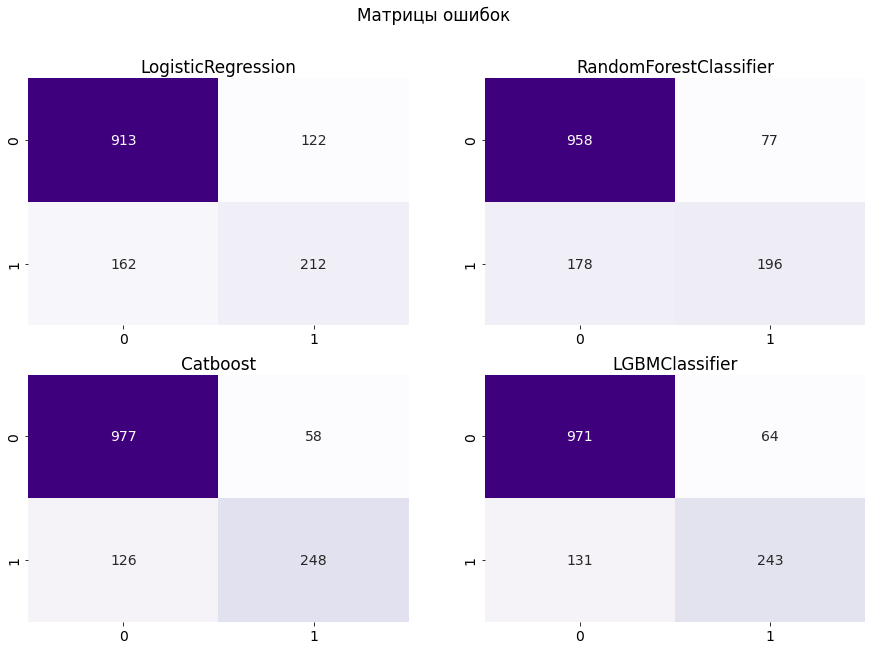

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.heatmap(confusion_matrix(y_test, predictions[0]), annot=True, fmt='d',cmap="Purples",cbar=False, 
                ax = axes[0, 0]).set(title='LogisticRegression')
sns.heatmap(confusion_matrix(y_test, predictions[1]), annot=True, fmt='d',cmap="Purples",cbar=False, 
                ax = axes[0, 1]).set(title='RandomForestClassifier')
sns.heatmap(confusion_matrix(y_test, predictions[2]), annot=True, fmt='d',cmap="Purples",cbar=False, 
                ax = axes[1, 0]).set(title='Catboost')
sns.heatmap(confusion_matrix(y_test, predictions[3]), annot=True, fmt='d',cmap="Purples",cbar=False, 
                ax = axes[1, 1]).set(title='LGBMClassifier')
fig.suptitle('Матрицы ошибок')
plt.show()

Все использованные нами модели оказались лучше константной. Самой лучшей оказалась модель CatBoostClassifier с метрикой AUC-ROC = 0.91 на тесте.

## Анализ важности признаков

Для лучшей модели проведем анализ важности признаков.

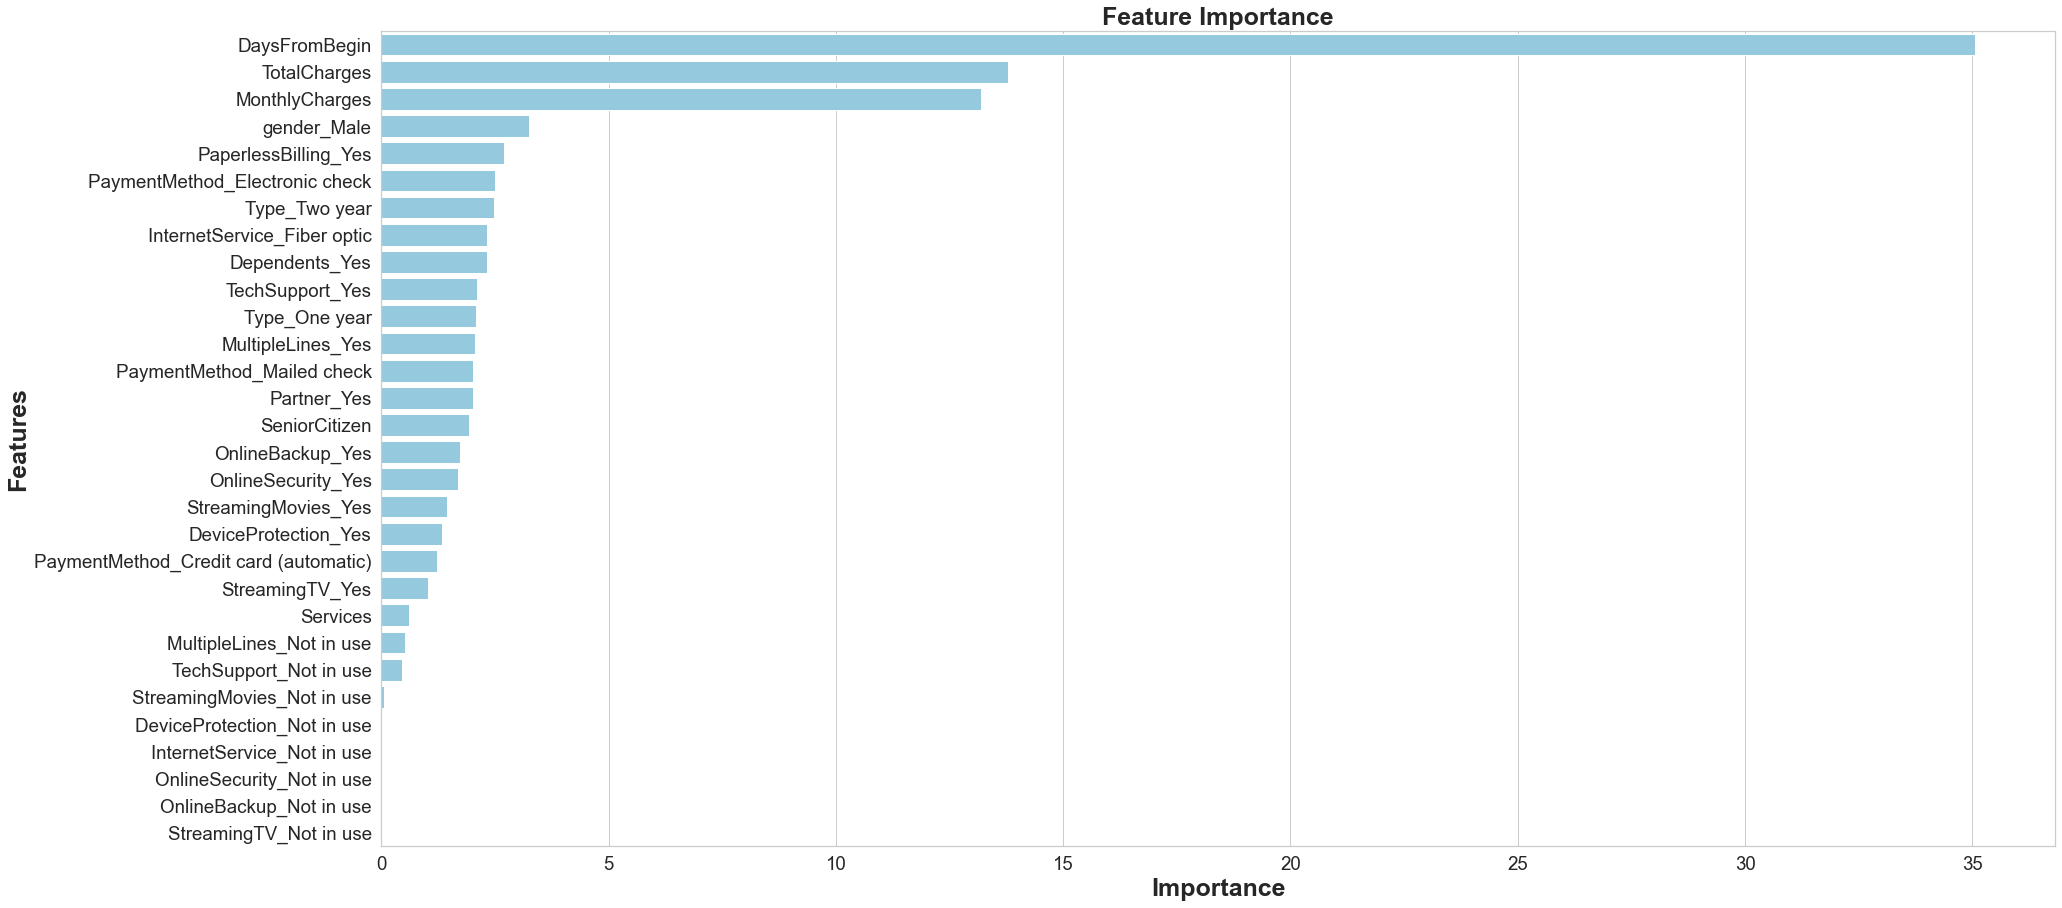

In [61]:
feats = {}
for feature, importance in zip(X.columns, cat_cl.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Наиболее важными признаками для нашей модели оказались количество дней от заключения договора, общий платеж и ежемесячный платеж.

## Вывод

Мы провели анализ признаков и выявлены следующее:
 * в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся;
 * ушедшие клиенты чаще использовали несколько линий, а не одну, а к интернету были подключены с помощью оптоволокна;
 * ушедшие клиенты чаще используют помесячный способ оплаты, тогда как лояльные клиенты наравне с помесячным используют и годовой и двухгодовой планы;
 * многие ушедшие клиенты расплачивались методом 'Electronic check';
 * пол не является показателем оттока клиентов;  
 * количество людей пенсионного возраста значительно меньше, чем молодого поколения, однако отток пожилых людей почти в 2 раза больше, чем для молодых людей;  
 * люди, не имеющие партнера, более склонны к расторжению договора;  
 * люди без иждивенцев тоже склонны к уходу;

Обучены различные модели бинарной классификации для предсказания оттока клиентов. Для проверки качества моделей использовались метрика roc_auc.

Все использованные нами модели оказались лучше константной. Самой лучшей оказалась модель CatBoostClassifier с метрикой AUC-ROC = 0.91 на тесте. Наиболее важными признаками для нашей модели оказались количество дней от заключения договора, общий платеж и ежемесячный платеж.

## Отчет по решению

Перед нами была поставлена задача прогнозирования оттока клиентов для оператора связи «Ниединогоразрыва.ком». На полученных данных нами был проведен исследовательский анализ и составлен план дальнейших действий для выполнения задачи, состоящий из трех пунктов:
* Масштабировать численные признаки
* Разделить данные на выборки
* Обучить несколько моделей с подбором гиперпараметров

Все пункты плана были выполнены.

При выполнении задачи мы выделили следующие ключевые шаги:
1. Загрузка и обзор данных для знакомства со структурой и выявления ошибок в данных.
2. Предобработка данных - изменение типов данных, заполнение пропусков, объединение данных в одну таблицу для удобства работы.
3. Создание дополнительных признаков.
4. Исследовательский анализ данных, поиск корреляций между целевым признаком и остальными.
5. Обучение нескольких моделей с подбором гиперпараметров и выбор наилучшей из них.
6. Анализ важности признаков для обучения модели.

Итоговой моделью стала модель CatBoostClassifier с метрикой AUC-ROC = 0.91.